# Imports

In [104]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,LabelEncoder, MinMaxScaler
from sklearn.feature_selection import SelectKBest, f_classif, chi2, RFE
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import lightgbm as lgb
from catboost import CatBoostClassifier, Pool
# Logistic Regresss is not yet supported by SHAP
import shap

## Load the dataset


In [105]:
df = pd.read_csv('../dataset/strokeDataSet.csv')

# Data Cleaning

In [106]:
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [107]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [108]:
df.describe()


,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,36517.829354,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,21161.721625,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,67.000000,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,17741.250000,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,36932.000000,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,54682.000000,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,72940.000000,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


### age:
    Mean age is 43.2 years, suggesting the dataset includes both younger and older adults. \
    Std Dev of 22.6 is large, age is widely spread. \
    Min value is 0.08: possibly an infant. \
    Max is 82: includes elderly individuals, a known stroke risk group.


### avg_glucose_level:
    Mean glucose is 106.15 mg/dL. \
    Std Dev is 45.28: indicates significant variation. \
    Max of 271.74 is very high: suggests presence of diabetic/hyperglycemic individuals. \

High glucose levels are risk factors for stroke, this feature may be important in modeling.

### bmi (Body Mass Index)
    Mean is 28.89: close to the overweight range (25–29.9). \
    Max is 97.6: likely indicates extreme obesity. \
    Std Dev is 7.85: some individuals may be underweight or obese.

BMI is a known cardiovascular risk factor, useful for stroke prediction.

### stroke (target variable)
    Mean of 0.049 = 4.9% of patients had a stroke.
    Values are only 0 or 1: this is a binary classification task.
    Highly imbalanced: 95% non-stroke, 5% stroke.

Class imbalance is a challenge, models will need techniques like SMOTE or class weighting.

In [109]:
df.isnull().sum()


id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

In [110]:
df.duplicated().sum()
df = df[df['gender'] != 'Other'] # there is only 1 Other gender, so we can drop it
df.dropna(subset=['bmi'], inplace=True)


### Data Overview & Cleaning
This dataset contains a total of 5,110 rows with no duplicate, and the 'bmi' parameter has 201 missing values. These missing values were filled using the median, based on the assumption that the individuals with missing 'bmi' entries have typical or average bmi values.

### Columns:
1) id: unique identifier
2) gender: "Male", "Female"
3) age: age of the patient
4) hypertension: 0 if the patient doesn't have hypertension, 1 if the patient has hypertension
5) heart_disease: 0 if the patient doesn't have any heart diseases, 1 if the patient has a heart disease
6) ever_married: "No" or "Yes"
7) work_type: "children", "Govt_jov", "Never_worked", "Private" or "Self-employed"
8) Residence_type: "Rural" or "Urban"
9) avg_glucose_level: average glucose level in blood
10) bmi: body mass index
11) smoking_status: "formerly smoked", "never smoked", "smokes" or "Unknown"*
12) stroke: 1 if the patient had a stroke or 0 if not

In [111]:
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
categorical_cols = [col for col in categorical_cols if col != 'stroke']

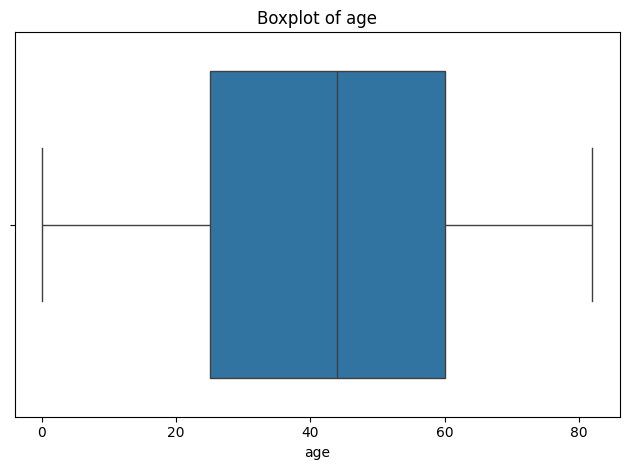

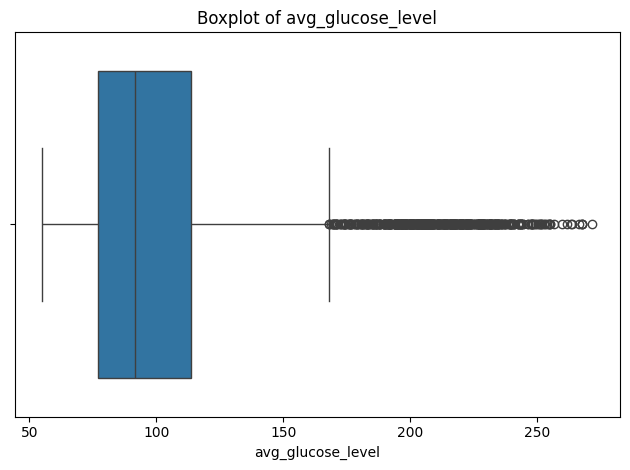

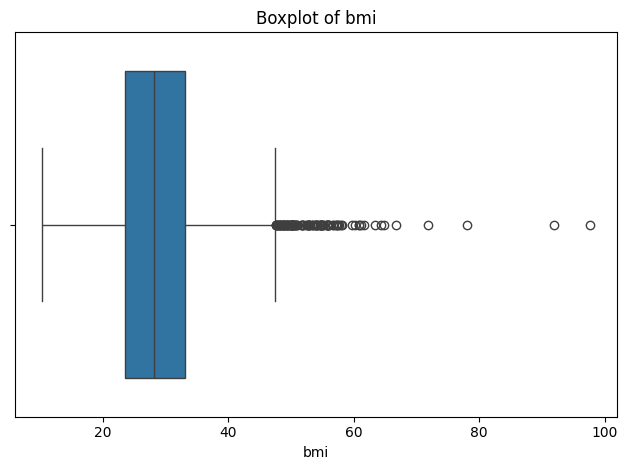

In [112]:
numerical_features = ['age', 'avg_glucose_level', 'bmi']

for col in numerical_features:
    sns.boxplot(x=df[col])
    plt.title(f'Boxplot of {col}')
    plt.savefig(f'boxplot_{col}.png')
    plt.tight_layout()
    plt.show()


### Interpret boxplots

Boxplots show outliers in bmi and glucose level, but this is reflect the real patient conditions. A stroke patient may actually have a BMI of 90 or glucose of 270, so removing these would hide critical clinical cases!

They are rare but valid, outliers in this dataset can help catch severe cases that models should learn.

### Formal Feature Selection


In [113]:
class FormalFeatureSelection:
    def __init__(self, df, features, label):
        self.df = df
        self.features = features
        self.label = label
    
    def getX(self):
        return self.features
    
    def getY(self):
        return self.labels
        
    def selectTopFeatures(self, top_n_anova=5, top_n_chi=5, top_n_rf=5, include_ref=5):
        self.featureSelectionSummary()
        top_features = self.feature_selection_summary
        anova_top = (
            top_features["Anova F"].sort_values(ascending=False).head(top_n_anova).index
        )
        chi2_top = (
            top_features["CHI2"].sort_values(ascending=False).head(top_n_chi).index
        )
        rf_top = (
            top_features["RF Importance"].sort_values(ascending=False).head(top_n_rf).index
        )
        rfe_top = (
            top_features["RFE Support"].sort_values(ascending=False).head(include_ref).index
        )
        self.top_features = set(anova_top).union(chi2_top).union(rf_top).union(rfe_top)
        display(top_features.loc[list(self.top_features)])

    def featureSelectionSummary(self):
        features = self.df.drop(columns=self.label)
        self.labels = self.df[self.label]
        self.features = pd.get_dummies(features)        
        
        #Anova F-Test
        skb_f = SelectKBest(score_func=f_classif, k="all").fit(self.features, self.labels)
        anova_scores = pd.Series(skb_f.scores_, index=self.features.columns).sort_values(ascending=False)

        #Normalize for Chi2
        scaler = MinMaxScaler()
        features_scaled = pd.DataFrame(
            scaler.fit_transform(self.features), columns=self.features.columns
        )
        
        #Chi2
        skb_chi2 = SelectKBest(score_func=chi2, k="all").fit(features_scaled, self.labels)
        chi2_scores = pd.Series(skb_chi2.scores_, index=self.features.columns).sort_values(ascending=False)

        #RandomForestImportances
        rf = RandomForestClassifier(random_state=0)
        rf.fit(self.features, self.labels)
        rf_scores = pd.Series(
            rf.feature_importances_, index=self.features.columns
        ).sort_values(ascending=False)

        #RFE - Logistic Regression
        lr = LogisticRegression(max_iter=4000)
        rfe = RFE(estimator=lr, n_features_to_select=10)
        rfe.fit(self.features, self.labels)
        rfe_support = pd.Series(rfe.support_, index=self.features.columns)

        
        self.feature_selection_summary = pd.DataFrame(
            {
                "Anova F": anova_scores,
                "CHI2": chi2_scores,
                "RF Importance": rf_scores,
                "RFE Support": rfe_support.astype(bool)
            }
        )
        

In [114]:
fs = FormalFeatureSelection(df.drop(columns=['id']).copy(deep=True), df.columns.drop('stroke').tolist(), 'stroke')
display("Running the following tests: AnovaF, CHI2, RF Importance and RFE Support for selecting the features")
display("Based on the scores selecting the following top features")
fs.selectTopFeatures(top_n_anova=10)


'Running the following tests: AnovaF, CHI2, RF Importance and RFE Support for selecting the features'

'Based on the scores selecting the following top features'

,Anova F,CHI2,RF Importance,RFE Support
avg_glucose_level,96.633134,17.210852,0.272907,False
smoking_status_formerly smoked,16.242036,13.436472,0.017791,False
bmi,8.811194,0.334319,0.223467,False
hypertension,101.691801,90.508836,0.028416,True
heart_disease,95.144282,88.749305,0.024598,True
work_type_Self-employed,15.069972,12.656637,0.018591,True
ever_married_Yes,54.745185,18.804795,0.009213,True
smoking_status_Unknown,27.787710,19.290029,0.014621,True
ever_married_No,54.745185,35.358312,0.008611,False
work_type_Private,1.100002,0.470299,0.021841,True


## Train Data

### Before applied selected features

In [115]:
for col in categorical_cols:
    df[col] = df[col].astype('category')

df_encoded = pd.get_dummies(df.drop(columns=['id']))
X_before = df_encoded.drop(columns=['stroke'])
y_before = df_encoded['stroke']

X_train_val_before, X_test_before, y_train_val_before, y_test_before = train_test_split(X_before, y_before, test_size=0.2, random_state=42, stratify=y_before)
X_train_before, X_val_before, y_train_before, y_val_before = train_test_split(X_train_val_before, y_train_val_before, test_size=0.25, random_state=42, stratify=y_train_val_before)

scaler = StandardScaler()
X_train_scaled_before = scaler.fit_transform(X_train_before)
X_val_scaled_before = scaler.transform(X_val_before)
X_test_scaled_before = scaler.transform(X_test_before)

smote = SMOTE(random_state=42)
X_train_smote_before, y_train_smote_before = smote.fit_resample(X_train_scaled_before, y_train_before)

### After applied selected features

In [116]:
##Selecting the features based on the formal feature selection.
selected_features = list(fs.top_features)

# Split features and labels
X_after = fs.getX()[selected_features]
y_after = fs.getY()

# Split data into training (60%), validation (20%), and test (20%) sets
X_train_val_after, X_test_after, y_train_val_after, y_test_after = train_test_split(X_after, y_after, test_size=0.2, random_state=42, stratify=y_after) 
X_train_after, X_val_after, y_train_after, y_val_after = train_test_split(X_train_val_after, y_train_val_after, test_size=0.25, random_state=42, stratify=y_train_val_after) 

# Scale the features
scaler = StandardScaler()
X_train_scaled_after = scaler.fit_transform(X_train_after)
X_val_scaled_after = scaler.transform(X_val_after)
X_test_scaled_after = scaler.transform(X_test_after)

# Apply SMOTE to handle class imbalance
smote = SMOTE(random_state=42)
X_train_smote_after, y_train_smote_after = smote.fit_resample(X_train_scaled_after, y_train_after)


# EDA

## Univariate Distribution

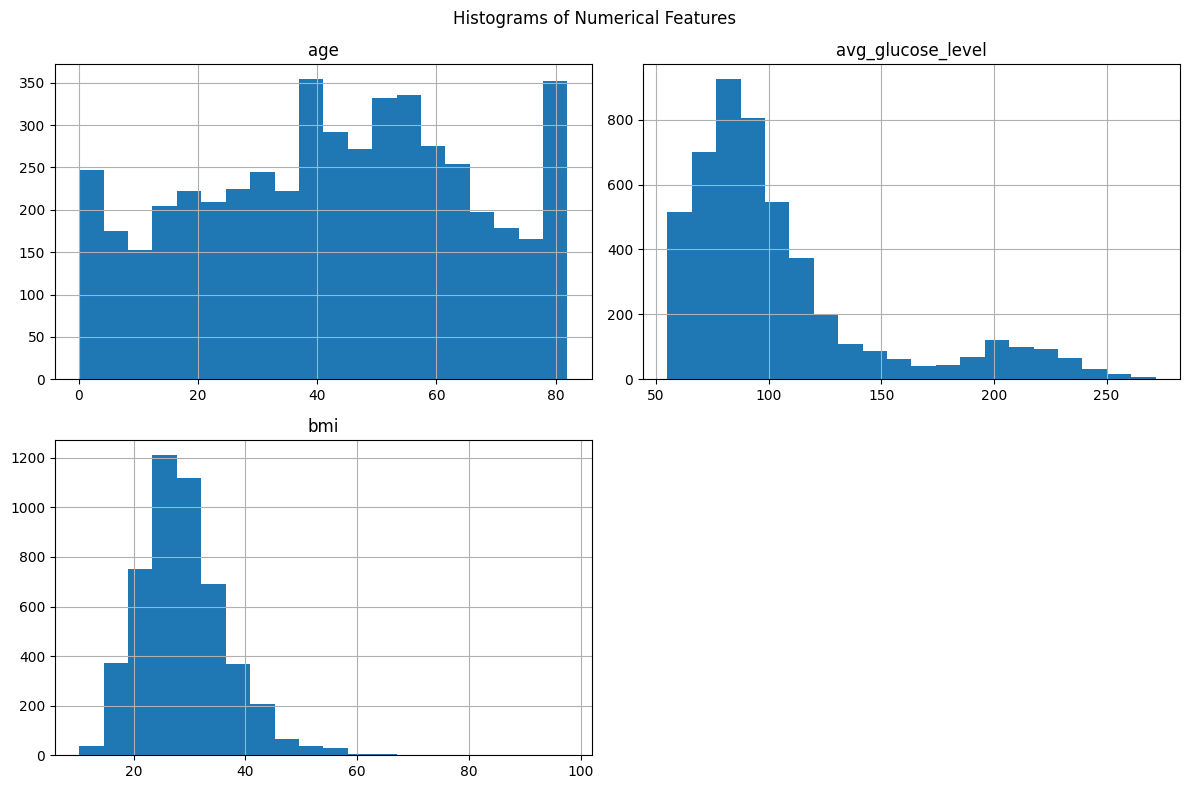

In [117]:
num_cols = ['age', 'avg_glucose_level', 'bmi']
df[num_cols].hist(bins=20, figsize=(12, 8))
plt.suptitle('Histograms of Numerical Features')
plt.savefig('histograms_numerical_features.png')
plt.tight_layout()
plt.show()

Numerical histograms: "age, avg_glucose_level, bmi" show right-skewed distributions, especially "avg_glucose_level".

Stroke distribution shows heavy imbalance between class 1 (stroke) and class 0 (no stroke) in the dataset. Class 1 is much less than Class 0. This could lead to poor model evaluation. To address this issue, we will use stratified sampling, SMOTE, and class weighting to improve the prediction of class 1 (stroke).  

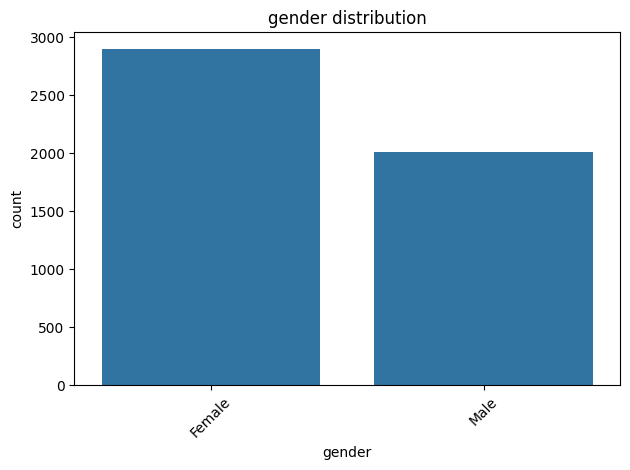

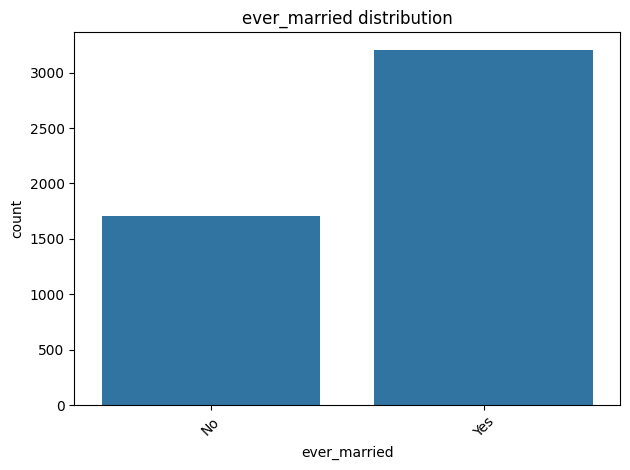

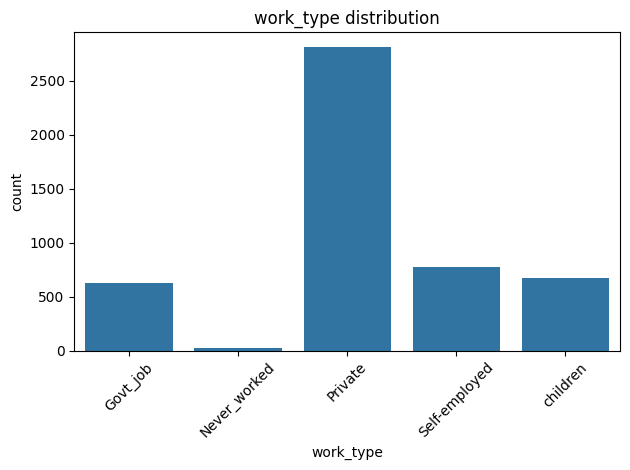

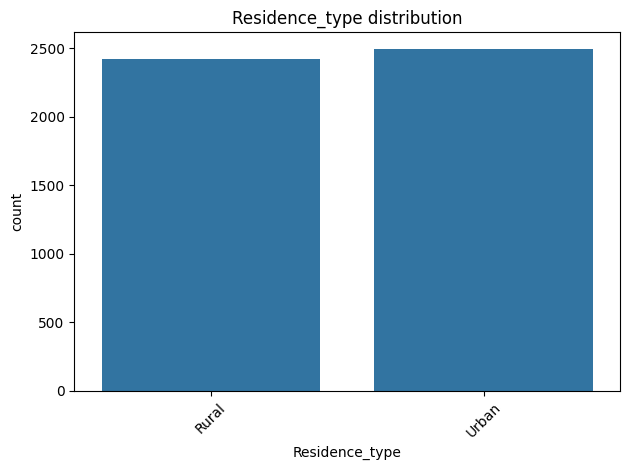

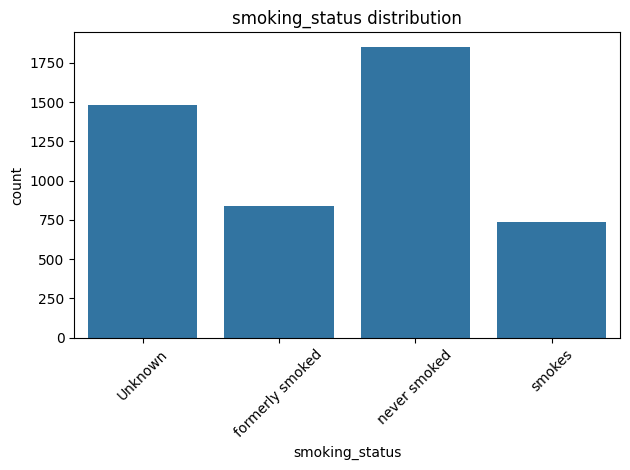

In [118]:
for col in categorical_cols:
    sns.countplot(x=col, data=df)
    plt.title(f'{col} distribution')
    plt.xticks(rotation=45)
    plt.savefig(f'countplot_{col}.png')
    plt.tight_layout()
    plt.show()

Categorical countplots like gender, smoking_status, work_type show: most patients are female and have never smoked. Majority work in the private sector.

# Bivariate Analysis

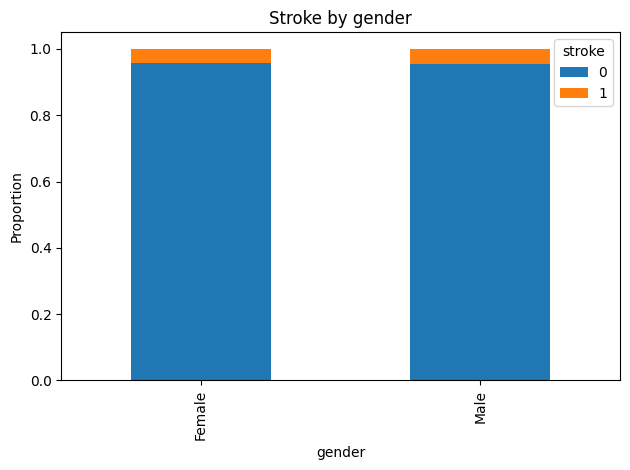

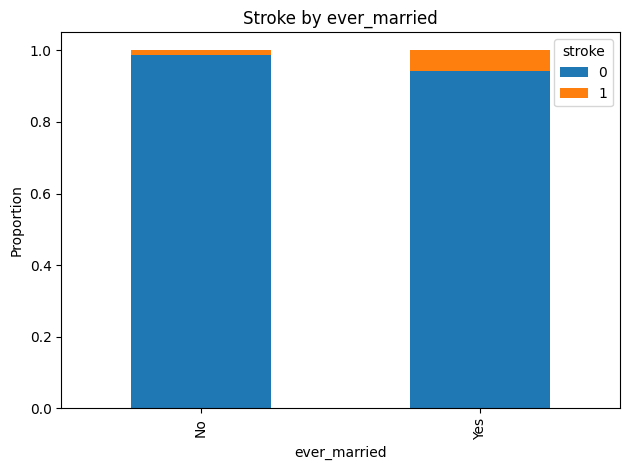

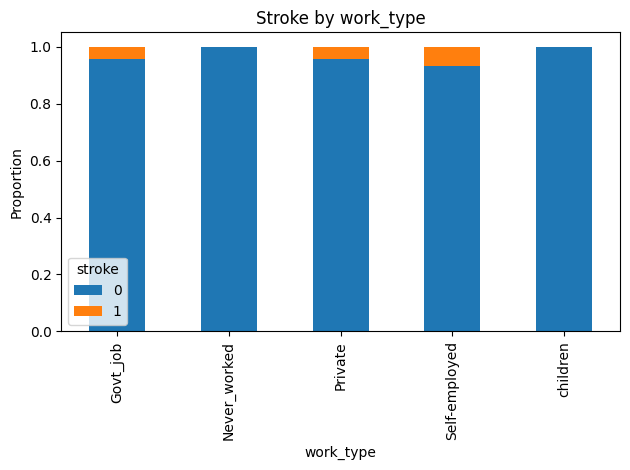

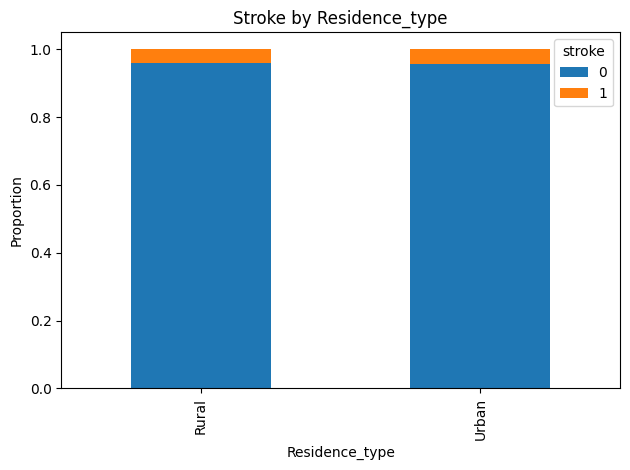

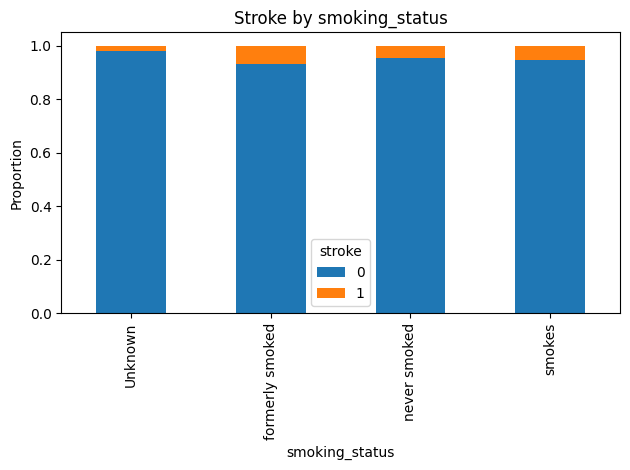

In [119]:
for col in categorical_cols:
    pd.crosstab(df[col], df['stroke'], normalize='index').plot(kind='bar', stacked=True)
    plt.title(f'Stroke by {col}')
    plt.ylabel('Proportion')
    plt.savefig(f'stroke_by_{col}.png')
    plt.tight_layout()
    plt.show()

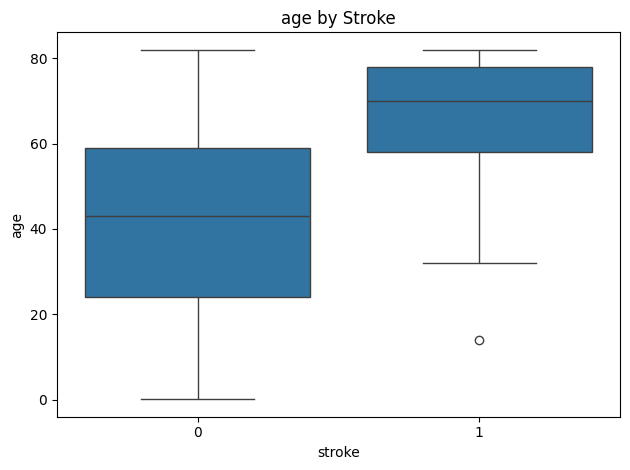

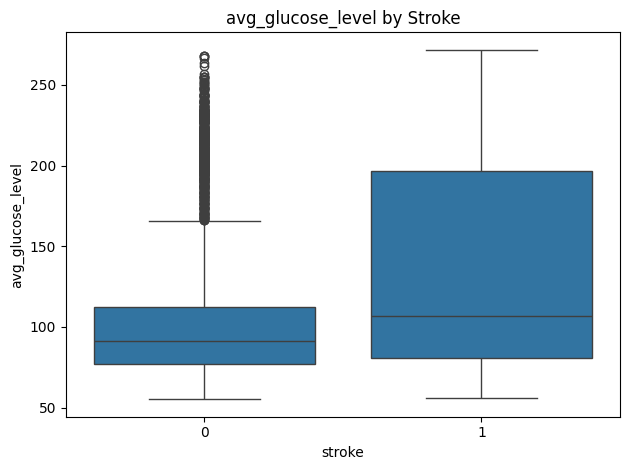

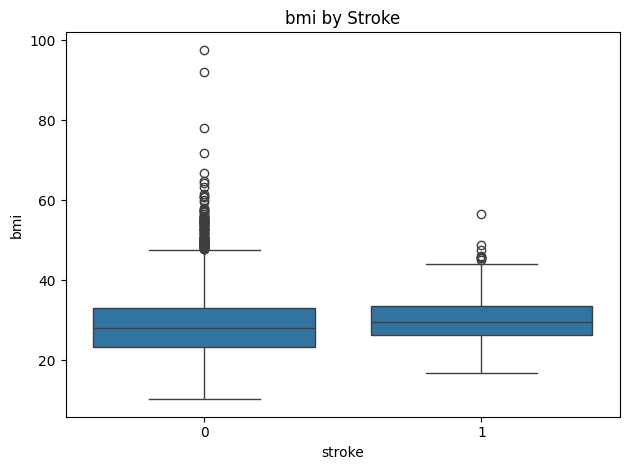

In [120]:
for col in num_cols:
    sns.boxplot(x='stroke', y=col, data=df)
    plt.title(f'{col} by Stroke')
    plt.savefig(f'boxplot_{col}_by_stroke.png') 
    plt.tight_layout()
    plt.show()

#### Outliers are retained because they reflected severe clinical situations that could be associated with stroke

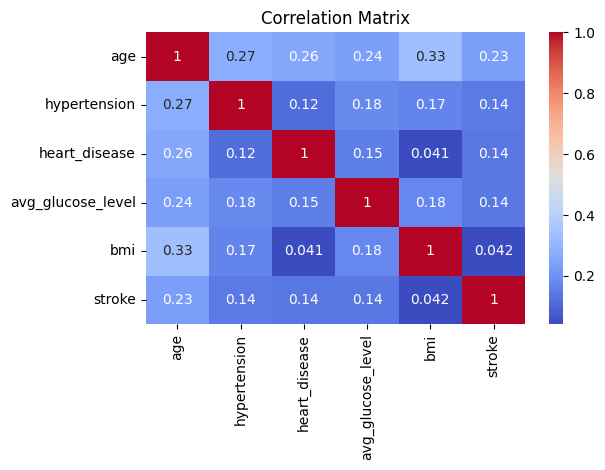

In [121]:
corr = df[['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi', 'stroke']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.savefig('correlation_matrix.png')
plt.tight_layout()  
plt.show()

### Summary of Bivariate Analysis
| Feature        | Strength of Association with Stroke  | Notes                                                     |
| -------------- | -----------------------------------  | ------------------------------------------------------    |
| Age            | Strong                               | Older people much more likely to have stroke              |
| Glucose Level  | Moderate                             | High glucose is a risk factor                             |
| Smoking Status | Moderate                             | "Formerly smoked" and "smokes" show elevated stroke risk  |
| Hypertension   | Moderate                             | Medically important though correlation is weak            |
| Heart Disease  | Moderate                             | Similar to hypertension                                   |
| Ever Married   | Weak to Moderate                     | Marginal relationship with stroke
| Work Type      | Weak to Moderate                     | "Self-employed" and "Govt job" higher                     |
| BMI            | Weak                                 | Not strongly correlated alone                             |
| Gender         | Very Weak                            | No major difference                                       |
| Residence Type | None                                 | Urban and rural similar                                   |


# ANN model

In [122]:
# -------------------------------
# Train ANN BEFORE feature selection WITH SMOTE
# -------------------------------
ann_model_before = MLPClassifier(
    hidden_layer_sizes=(64, 32),
    activation='relu',
    max_iter=500,
    random_state=42
)
ann_model_before.fit(X_train_smote_before, y_train_smote_before)

# Evaluate on validation and test sets
val_preds_ann_before = ann_model_before.predict(X_val_scaled_before)
test_preds_ann_before = ann_model_before.predict(X_test_scaled_before)

print("ANN Performance BEFORE Feature Selection WITH SMOTE: \n")
print("Validation Accuracy:", accuracy_score(y_val_before, val_preds_ann_before))
print("Test Accuracy:", accuracy_score(y_test_before, test_preds_ann_before))
print("Validation Classification Report:\n", classification_report(y_val_before, val_preds_ann_before))
print("Test Classification Report:\n", classification_report(y_test_before, test_preds_ann_before))

# -------------------------------
# Train ANN AFTER feature selection WITH SMOTE
# -------------------------------
ann_model_after = MLPClassifier(
    hidden_layer_sizes=(64, 32),
    activation='relu',
    max_iter=500,
    random_state=42
)
ann_model_after.fit(X_train_smote_after, y_train_smote_after)

# Evaluate on validation and test sets
val_preds_ann_after = ann_model_after.predict(X_val_scaled_after)
test_preds_ann_after = ann_model_after.predict(X_test_scaled_after)

print("ANN Performance AFTER Feature Selection WITH SMOTE: \n")
print("Validation Accuracy:", accuracy_score(y_val_after, val_preds_ann_after))
print("Test Accuracy:", accuracy_score(y_test_after, test_preds_ann_after))
print("Validation Classification Report:\n", classification_report(y_val_after, val_preds_ann_after))
print("Test Classification Report:\n", classification_report(y_test_after, test_preds_ann_after))

ANN Performance BEFORE Feature Selection WITH SMOTE: 

Validation Accuracy: 0.9114052953156823
Test Accuracy: 0.9205702647657841
Validation Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.95      0.95       940
           1       0.09      0.12      0.10        42

    accuracy                           0.91       982
   macro avg       0.53      0.53      0.53       982
weighted avg       0.92      0.91      0.92       982

Test Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.95      0.96       940
           1       0.17      0.21      0.19        42

    accuracy                           0.92       982
   macro avg       0.57      0.58      0.57       982
weighted avg       0.93      0.92      0.93       982

ANN Performance AFTER Feature Selection WITH SMOTE: 

Validation Accuracy: 0.8981670061099797
Test Accuracy: 0.895112016293279
Validation Classification 

# Logistic Regression model

In [123]:
# -------------------------------
# Train Logistic Regression BEFORE Feature Selection WITH SMOTE
# -------------------------------
lr_model_before = LogisticRegression(max_iter=1000, random_state=42)
lr_model_before.fit(X_train_smote_before, y_train_smote_before)

# Evaluate on validation and test sets
val_preds_lr_before = lr_model_before.predict(X_val_scaled_before)
test_preds_lr_before = lr_model_before.predict(X_test_scaled_before)

print("Logistic Regression Performance BEFORE Feature Selection WITH SMOTE: \n")
print("Validation Accuracy:", accuracy_score(y_val_before, val_preds_lr_before))
print("Test Accuracy:", accuracy_score(y_test_before, test_preds_lr_before))
print("Validation Classification Report:\n", classification_report(y_val_before, val_preds_lr_before, zero_division=0))
print("Test Classification Report:\n", classification_report(y_test_before, test_preds_lr_before, zero_division=0))

# -------------------------------
# Train Logistic Regression AFTER Feature Selection WITH SMOTE
# -------------------------------
lr_model_after = LogisticRegression(max_iter=1000, random_state=42)
lr_model_after.fit(X_train_smote_after, y_train_smote_after)

# Evaluate on validation and test sets
val_preds_lr_after = lr_model_after.predict(X_val_scaled_after)
test_preds_lr_after = lr_model_after.predict(X_test_scaled_after)

print("Logistic Regression Performance AFTER Feature Selection WITH SMOTE: \n")
print("Validation Accuracy:", accuracy_score(y_val_after, val_preds_lr_after))
print("Test Accuracy:", accuracy_score(y_test_after, test_preds_lr_after))
print("Validation Classification Report:\n", classification_report(y_val_after, val_preds_lr_after, zero_division=0))
print("Test Classification Report:\n", classification_report(y_test_after, test_preds_lr_after, zero_division=0))

Logistic Regression Performance BEFORE Feature Selection WITH SMOTE: 

Validation Accuracy: 0.7820773930753564
Test Accuracy: 0.7657841140529531
Validation Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.79      0.87       940
           1       0.13      0.71      0.22        42

    accuracy                           0.78       982
   macro avg       0.56      0.75      0.55       982
weighted avg       0.95      0.78      0.85       982

Test Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.77      0.86       940
           1       0.11      0.64      0.19        42

    accuracy                           0.77       982
   macro avg       0.55      0.71      0.53       982
weighted avg       0.94      0.77      0.83       982

Logistic Regression Performance AFTER Feature Selection WITH SMOTE: 

Validation Accuracy: 0.7769857433808554
Test Accuracy: 0.7668024439

In [124]:
coef_df = pd.DataFrame({
    'Feature': X_before.columns,
    'Coefficient': lr_model_before.coef_[0]
}).sort_values(by='Coefficient', ascending=False)

print("Logistic Regression Coefficients:\n", coef_df)

Logistic Regression Coefficients:
                            Feature  Coefficient
0                              age     2.335506
13              work_type_children     0.619284
19           smoking_status_smokes     0.207334
3                avg_glucose_level     0.199168
17  smoking_status_formerly smoked     0.181494
1                     hypertension     0.163492
7                  ever_married_No     0.144985
4                              bmi     0.058639
5                    gender_Female     0.018819
2                    heart_disease     0.018777
14            Residence_type_Rural     0.001626
15            Residence_type_Urban    -0.001626
6                      gender_Male    -0.018819
11               work_type_Private    -0.021209
18     smoking_status_never smoked    -0.057312
10          work_type_Never_worked    -0.078620
8                 ever_married_Yes    -0.144985
12         work_type_Self-employed    -0.193478
16          smoking_status_Unknown    -0.250187
9    

In this dataset, age has the strongest positive contributor to stroke risk.

# Gradient Boosting

### XGBoost

In [125]:
#-------------------------------
# Train XGBoost BEFORE Feature Selection WITHOUT SMOTE
#-------------------------------

xgb_before = XGBClassifier(
    use_label_encoder=False, # use_label_encoder=False to avoid deprecared automic encoding for target values
    eval_metric='logloss', # eval_metric='logloss' to optimize for binary classification
    random_state=42,
    scale_pos_weight = (y_train_before == 0).sum() / (y_train_before == 1).sum(), # handle class imbalance
    max_depth=4, # control tree complexity
    learning_rate=0.1, # smaller learning steps
    n_estimators=100, # number of boosting rounds
    subsample=0.8, # random sample of rows
    colsample_bytree=0.8 # random sample of features
)
xgb_before.fit(X_train_scaled_before, y_train_before)

# Evaluate XGBoost
val_preds_xgb_before = xgb_before.predict(X_val_scaled_before)
test_preds_xgb_before = xgb_before.predict(X_test_scaled_before)

print("XGBoost Performance BEFORE Feature Selection WITHOUT SMOTE: \n")
print("XGBoost Validation Accuracy:", accuracy_score(y_val_before, val_preds_xgb_before))
print("XGBoost Test Accuracy:", accuracy_score(y_test_before, test_preds_xgb_before))
print("XGBoost Validation Classification Report:\n", classification_report(y_val_before, val_preds_xgb_before))
print("XGBoost Test Classification Report:\n", classification_report(y_test_before, test_preds_xgb_before))

#-------------------------------
# Train XGBoost AFTER Feature Selection WITHOUT SMOTE
#-------------------------------

xgb_after = XGBClassifier(
    use_label_encoder=False, # use_label_encoder=False to avoid deprecared automic encoding for target values
    eval_metric='logloss', # eval_metric='logloss' to optimize for binary classification
    random_state=42,
    scale_pos_weight = (y_train_after == 0).sum() / (y_train_after == 1).sum(), # handle class imbalance
    max_depth=4, # control tree complexity
    learning_rate=0.1, # smaller learning steps
    n_estimators=100, # number of boosting rounds
    subsample=0.8, # random sample of rows
    colsample_bytree=0.8 # random sample of features
)
xgb_after.fit(X_train_scaled_after, y_train_after)

# Evaluate XGBoost
val_preds_xgb_after = xgb_after.predict(X_val_scaled_after)
test_preds_xgb_after = xgb_after.predict(X_test_scaled_after)

print("XGBoost Performance BEFORE Feature Selection WITHOUT SMOTE: \n")
print("XGBoost Validation Accuracy:", accuracy_score(y_val_after, val_preds_xgb_after))
print("XGBoost Test Accuracy:", accuracy_score(y_test_after, test_preds_xgb_after))
print("XGBoost Validation Classification Report:\n", classification_report(y_val_after, val_preds_xgb_after))
print("XGBoost Test Classification Report:\n", classification_report(y_test_after, test_preds_xgb_after)) 

XGBoost Performance BEFORE Feature Selection WITHOUT SMOTE: 

XGBoost Validation Accuracy: 0.8747454175152749
XGBoost Test Accuracy: 0.8523421588594705
XGBoost Validation Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.89      0.93       940
           1       0.15      0.43      0.23        42

    accuracy                           0.87       982
   macro avg       0.56      0.66      0.58       982
weighted avg       0.94      0.87      0.90       982

XGBoost Test Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.87      0.92       940
           1       0.12      0.40      0.19        42

    accuracy                           0.85       982
   macro avg       0.55      0.64      0.55       982
weighted avg       0.93      0.85      0.89       982

XGBoost Performance BEFORE Feature Selection WITHOUT SMOTE: 

XGBoost Validation Accuracy: 0.8767820773930753
XGBo

c:\Users\andrew.tran\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\training.py:183: UserWarning: [12:11:59] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\andrew.tran\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\training.py:183: UserWarning: [12:11:59] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


### Light GBM

In [126]:
#-------------------------------
# Train Light GBM BEFORE Feature Selection WITHOUT SMOTE
#-------------------------------
print("LGBM Performance BEFORE Feature Selection WITHOUT SMOTE: \n")

lgb_model_before = lgb.LGBMClassifier(random_state=42)
lgb_model_before.fit(X_train_scaled_before, y_train_before)

#Evaluate Light GBM
val_preds_lgbm_before = lgb_model_before.predict(X_val_scaled_before)
test_preds_lgbm_before = lgb_model_before.predict(X_test_scaled_before)

#y_probs = lgb_model.predict_proba(X_test_scaled_before)[:, 1]
#lgb_auc = roc_auc_score(y_test, lgb_model.predict_proba(X_test)[:,1])

print("LGBM Validation Accuracy:", accuracy_score(y_val_before, val_preds_lgbm_before))
print("LGBM Test Accuracy:", accuracy_score(y_test_before, test_preds_lgbm_before))
print("LGBM Validation Classification Report:\n", classification_report(y_val_before, val_preds_lgbm_before))
print("LGBM Test Classification Report:\n", classification_report(y_test_before, test_preds_lgbm_before))

#-------------------------------
# Train Light GBM AFTER Feature Selection WITHOUT SMOTE
#-------------------------------
print("LGBM Performance AFTER Feature Selection WITHOUT SMOTE: \n")

lgb_model_after = lgb.LGBMClassifier(random_state=42)
lgb_model_after.fit(X_train_scaled_after, y_train_after)

#Evaluate Light GBM
val_preds_lgbm_after = lgb_model_after.predict(X_val_scaled_after)
test_preds_lgbm_after = lgb_model_after.predict(X_test_scaled_after)

#y_probs = lgb_model.predict_proba(X_test_scaled_before)[:, 1]
#lgb_auc = roc_auc_score(y_test, lgb_model.predict_proba(X_test)[:,1])

print("LGBM Validation Accuracy:", accuracy_score(y_val_after, val_preds_lgbm_after))
print("LGBM Test Accuracy:", accuracy_score(y_test_after, test_preds_lgbm_after))
print("LGBM Validation Classification Report:\n", classification_report(y_val_after, val_preds_lgbm_after))
print("LGBM Test Classification Report:\n", classification_report(y_test_after, test_preds_lgbm_after))

LGBM Performance BEFORE Feature Selection WITHOUT SMOTE: 

[LightGBM] [Info] Number of positive: 125, number of negative: 2819
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000171 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 656
[LightGBM] [Info] Number of data points in the train set: 2944, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.042459 -> initscore=-3.115824
[LightGBM] [Info] Start training from score -3.115824
LGBM Validation Accuracy: 0.9480651731160896
LGBM Test Accuracy: 0.9490835030549898
LGBM Validation Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.99      0.97       940
           1       0.15      0.05      0.07        42

    accuracy                           0.95       982
   macro avg       0.56      0.52      0.52   

c:\Users\andrew.tran\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\andrew.tran\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


LGBM Validation Accuracy: 0.9490835030549898
LGBM Test Accuracy: 0.945010183299389
LGBM Validation Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.99      0.97       940
           1       0.21      0.07      0.11        42

    accuracy                           0.95       982
   macro avg       0.59      0.53      0.54       982
weighted avg       0.93      0.95      0.94       982

LGBM Test Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.99      0.97       940
           1       0.07      0.02      0.04        42

    accuracy                           0.95       982
   macro avg       0.51      0.50      0.50       982
weighted avg       0.92      0.95      0.93       982



c:\Users\andrew.tran\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\andrew.tran\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


### Cat Boost

In [127]:
df_cat = df.copy(deep=True).drop(columns=['id'])

#Fill missing values
# Separate numeric and categorical columns
numeric_cols = df_cat.select_dtypes(include=[np.number]).columns

# Impute numeric columns with median
df_cat[numeric_cols] = SimpleImputer(strategy='median').fit_transform(df_cat[numeric_cols])

X_cat = df_cat.drop('stroke', axis=1)
y_cat = df_cat['stroke']

X_train_cat, X_test_cat, y_train_cat, y_test_cat = train_test_split(
    X_cat, y_cat, stratify=y_cat, test_size=0.2, random_state=42
)

# 7. Get indices of categorical columns (for CatBoost)
cat_features_indices = [X_cat.columns.get_loc(col) for col in categorical_cols]

cat_model = CatBoostClassifier(verbose=0, random_state=42)
cat_model.fit(X_train_cat, y_train_cat, cat_features=cat_features_indices)

test_preds_cat = cat_model.predict(X_test_cat)

y_probs_cat = cat_model.predict_proba(X_test_cat)[:, 1]


print("Cat Test Accuracy:", accuracy_score(y_test, test_preds_cat))
print("Cat Test Classification Report:\n", classification_report(y_test, test_preds_cat)) 

Cat Test Accuracy: 0.9562118126272913
Cat Test Classification Report:
               precision    recall  f1-score   support

           0       0.96      1.00      0.98       940
           1       0.33      0.02      0.04        42

    accuracy                           0.96       982
   macro avg       0.65      0.51      0.51       982
weighted avg       0.93      0.96      0.94       982



# Support Vector Machine (SVM) Model

In [128]:
#-------------------------------
# Train SVM model BEFORE Feature Selection WITH SMOTE
#-------------------------------
svm_model_before = SVC(kernel='linear', random_state=42)  # Using linear kernel for SVM
svm_model_before.fit(X_train_smote_before, y_train_smote_before)

# Evaluate SVM Regression
val_preds_svm_before = svm_model_before.predict(X_val_scaled_before)
test_preds_svm_before = svm_model_before.predict(X_test_scaled_before)

print("SVM Performance BEFORE Feature Selection WITH SMOTE: \n")
print("SVM Validation Accuracy:", accuracy_score(y_val_before, val_preds_svm_before))
print("SVM Test Accuracy:", accuracy_score(y_test_before, test_preds_svm_before))
print("SVM Validation Classification Report:\n", classification_report(y_val_before, val_preds_svm_before, zero_division=0)) # set undefined precision to zero    
print("SVM Test Classification Report:\n", classification_report(y_test_before, test_preds_svm_before, zero_division=0)) # set undefined precision to zero

#-------------------------------
# Train SVM model AFTER Feature Selection WITH SMOTE
#-------------------------------
svm_model_after = SVC(kernel='linear', random_state=42)  # Using linear kernel for SVM
svm_model_after.fit(X_train_smote_after, y_train_smote_after)

# Evaluate SVM Regression
val_preds_svm_after = svm_model_after.predict(X_val_scaled_after)
test_preds_svm_after = svm_model_after.predict(X_test_scaled_after)
print("SVM Performance AFTER Feature Selection WITH SMOTE: \n")
print("SVM Validation Accuracy:", accuracy_score(y_val_after, val_preds_svm_after))
print("SVM Test Accuracy:", accuracy_score(y_test_after, test_preds_svm_after))
print("SVM Validation Classification Report:\n", classification_report(y_val_after, val_preds_svm_after, zero_division=0)) # set undefined precision to zero    
print("SVM Test Classification Report:\n", classification_report(y_test_after, test_preds_svm_after, zero_division=0)) # set undefined precision to zero


SVM Performance BEFORE Feature Selection WITH SMOTE: 

SVM Validation Accuracy: 0.7759674134419552
SVM Test Accuracy: 0.7596741344195519
SVM Validation Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.78      0.87       940
           1       0.13      0.76      0.23        42

    accuracy                           0.78       982
   macro avg       0.56      0.77      0.55       982
weighted avg       0.95      0.78      0.84       982

SVM Test Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.76      0.86       940
           1       0.12      0.69      0.20        42

    accuracy                           0.76       982
   macro avg       0.55      0.73      0.53       982
weighted avg       0.95      0.76      0.83       982

SVM Performance AFTER Feature Selection WITH SMOTE: 

SVM Validation Accuracy: 0.7739307535641547
SVM Test Accuracy: 0.7596741344195519
S

# Compute and plot model prediction error

In [129]:
# Create dictionary with model names and their predictions
models_predictions = {
    "ANN Classifier": [test_preds_ann_before, test_preds_ann_after],
    "Logistic Regression": [test_preds_lr_before, test_preds_lr_after],
    "XGBoost": [test_preds_xgb_before, test_preds_xgb_after],
    "SVM": [test_preds_svm_before, test_preds_svm_after],
}

# Caculate and plot models confusion matrix and heatmap

In [130]:
# Loop through each model and compute confusion matrix
for model_name, predictions in models_predictions.items():
    print(f"\n {model_name} Confusion Matrices:")
    print("Before Feature Selection:")
    print(confusion_matrix(y_test_before, predictions[0]))
    print("After Feature Selection:")
    print(confusion_matrix(y_test_after, predictions[1]))


 ANN Classifier Confusion Matrices:
Before Feature Selection:
[[895  45]
 [ 33   9]]
After Feature Selection:
[[866  74]
 [ 29  13]]

 Logistic Regression Confusion Matrices:
Before Feature Selection:
[[725 215]
 [ 15  27]]
After Feature Selection:
[[726 214]
 [ 15  27]]

 XGBoost Confusion Matrices:
Before Feature Selection:
[[820 120]
 [ 25  17]]
After Feature Selection:
[[826 114]
 [ 23  19]]

 SVM Confusion Matrices:
Before Feature Selection:
[[717 223]
 [ 13  29]]
After Feature Selection:
[[717 223]
 [ 13  29]]


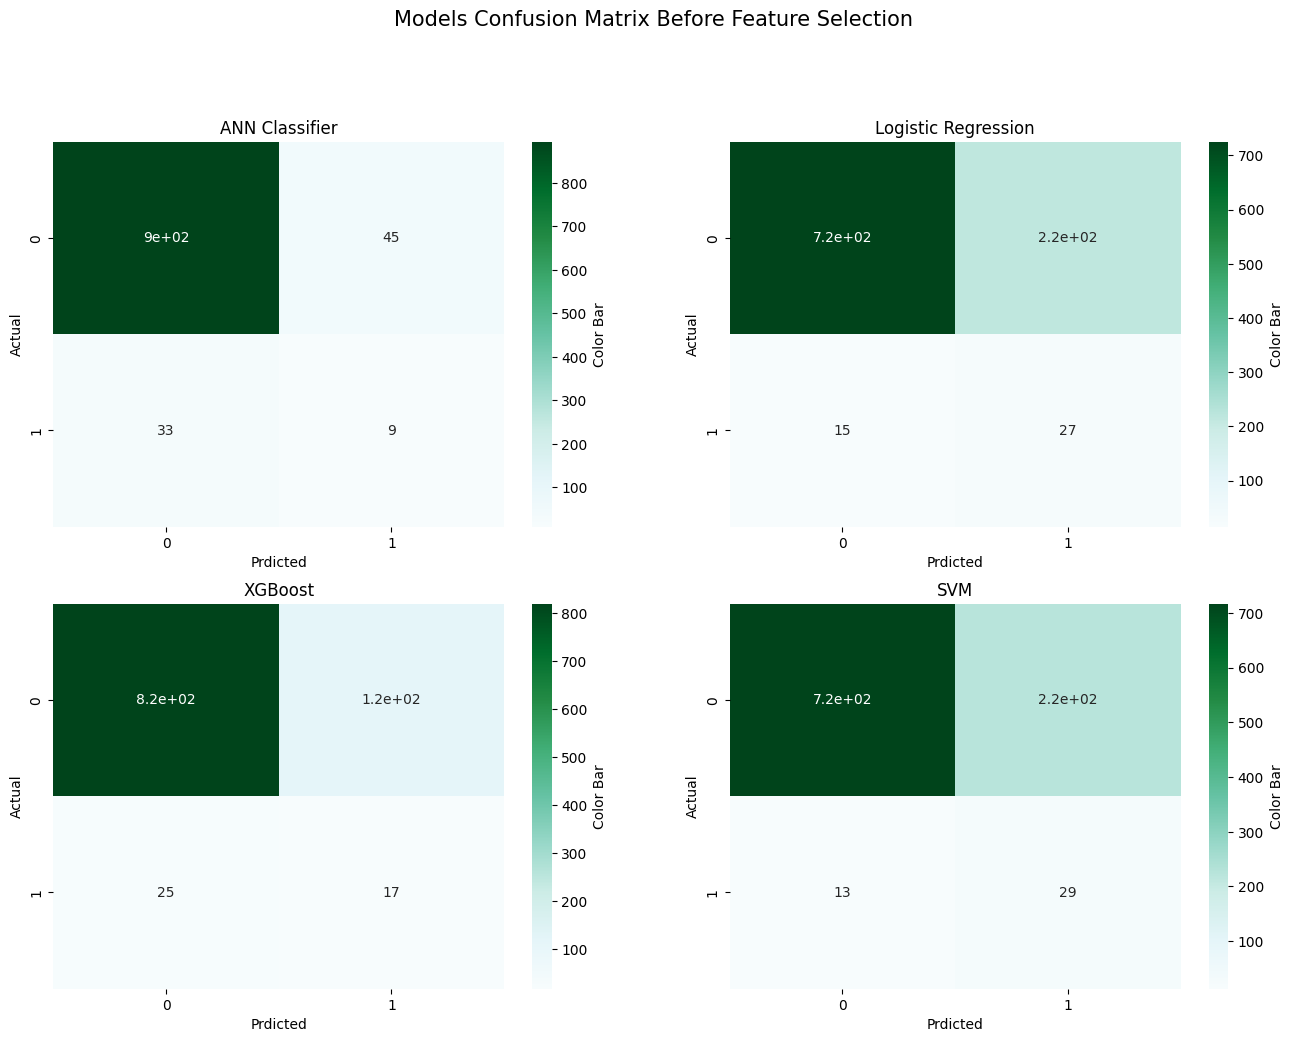

In [131]:
plt_num = 1
plt.figure(figsize=(16,11)) # Set figure size
for model_name, predictions in models_predictions.items():
    conf_matrix = confusion_matrix(y_test_before, predictions[0])
    plt.subplot(2, 2, plt_num)
    sns.heatmap(conf_matrix, cmap="BuGn", annot=True, cbar_kws={"label":"Color Bar"}) 
    plt.suptitle('Models Confusion Matrix Before Feature Selection', fontsize=15, y=1)  
    plt.title(model_name), plt.xlabel('Prdicted'), plt.ylabel('Actual')
    plt.savefig('Confusion_Matrix_Before.png')
    plt_num +=1

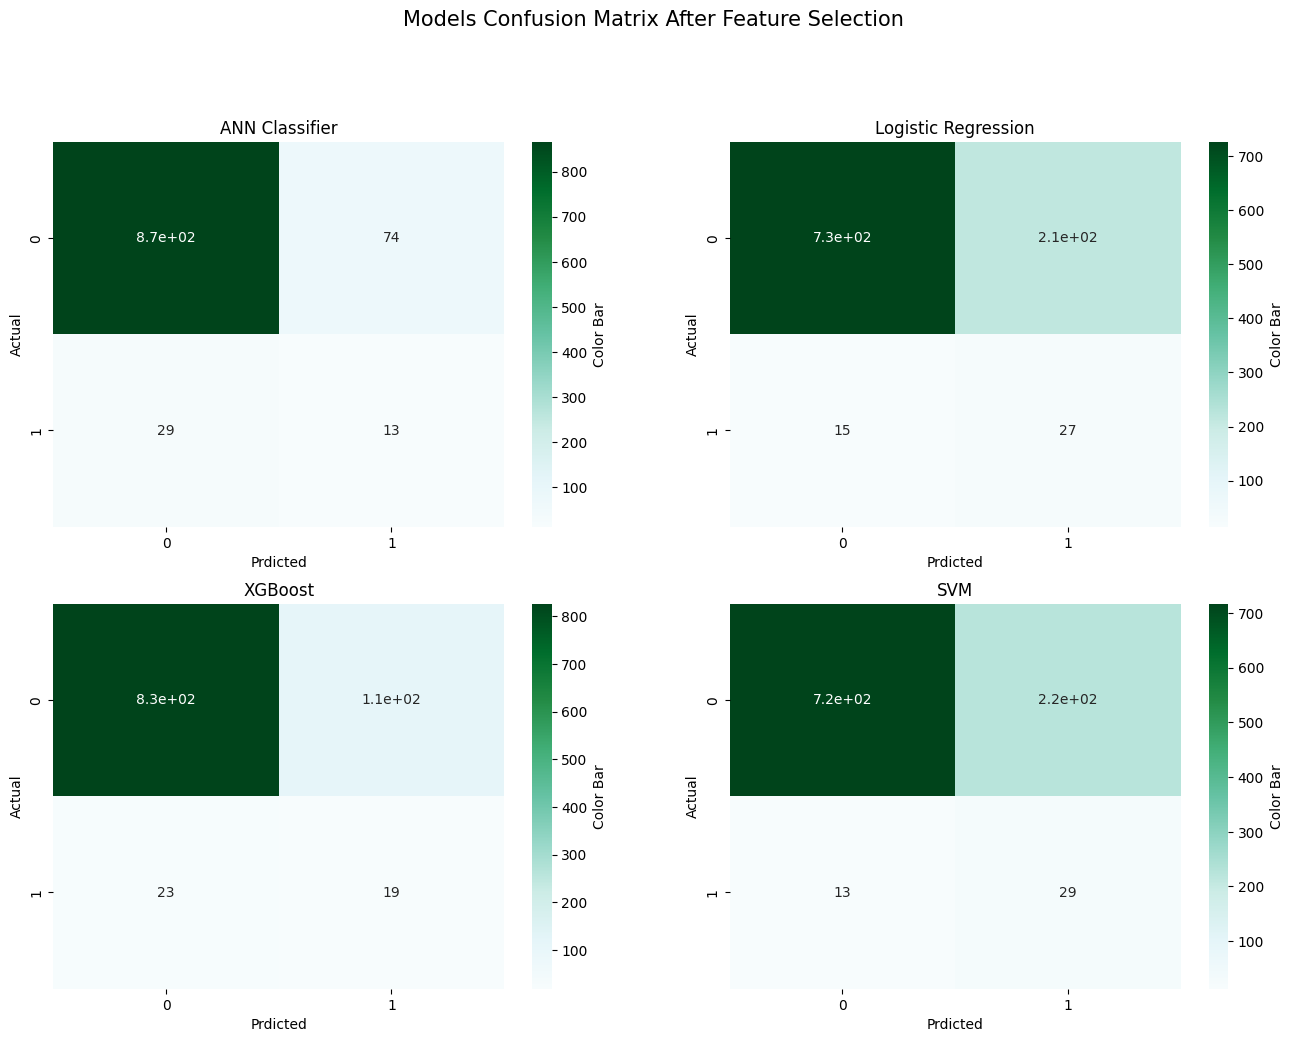

In [132]:
# Loop through each model and plot confusion matrix
plt_num = 1
plt.figure(figsize=(16,11)) # Set figure size
for model_name, predictions in models_predictions.items():
    conf_matrix = confusion_matrix(y_test_after, predictions[1])
    plt.subplot(2, 2, plt_num)
    sns.heatmap(conf_matrix, cmap="BuGn", annot=True, cbar_kws={"label":"Color Bar"}) 
    plt.suptitle('Models Confusion Matrix After Feature Selection', fontsize=15, y=1)  
    plt.title(model_name), plt.xlabel('Prdicted'), plt.ylabel('Actual')
    plt.savefig('Confusion_Matrix_After.png')
    plt_num +=1

Use SHAP (SHapley Additive exPlanations) tool for interpretability machine learning model. SHAP is a framework that explains the output of machine learning models using Shapley values from game theory. It fairly distributes each feature's contribution to individual predictions

Reference: 
Lundberg, S. M. (n.d.). Basic SHAP interaction value example in XGBoost. SHAP Documentation. https://shap.readthedocs.io/en/latest/example_notebooks/tabular_examples/tree_based_models/Basic%20SHAP%20Interaction%20Value%20Example%20in%20XGBoost.html

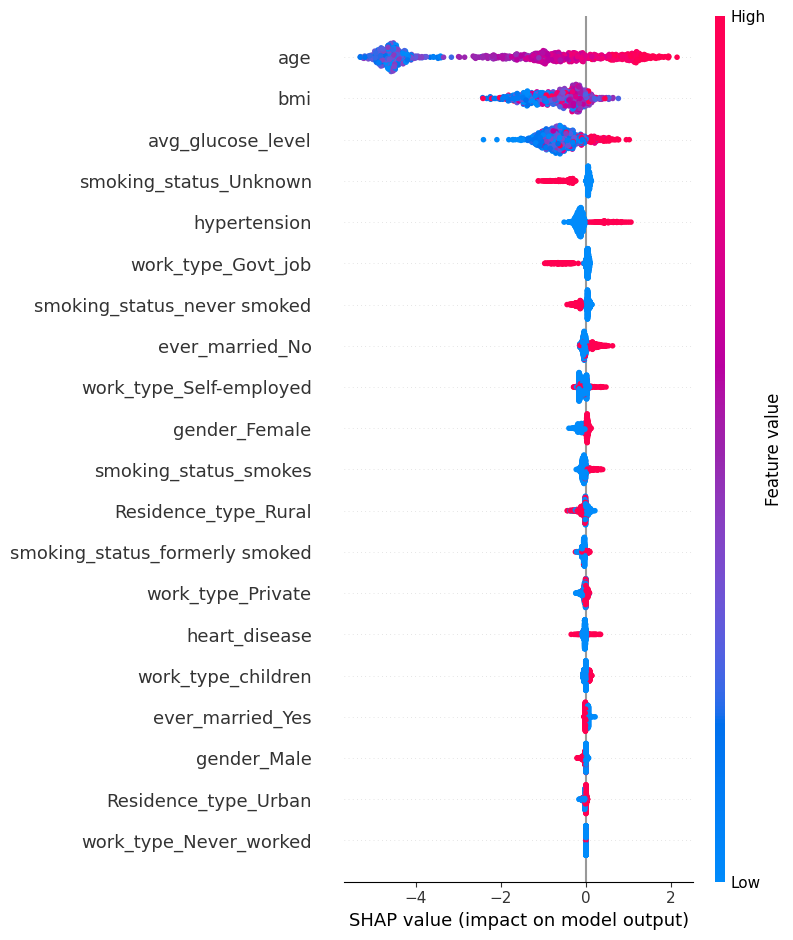

In [133]:
#model_name = [xgb]  # Use model objects, not strings
explainer = shap.TreeExplainer(xgb_before)
shap_values = explainer.shap_values(X_test_scaled_before)
shap.summary_plot(shap_values, X_test_scaled_before, feature_names=X_before.columns, show=False)
plt.savefig('SHAP_values_After.png')
plt.show()

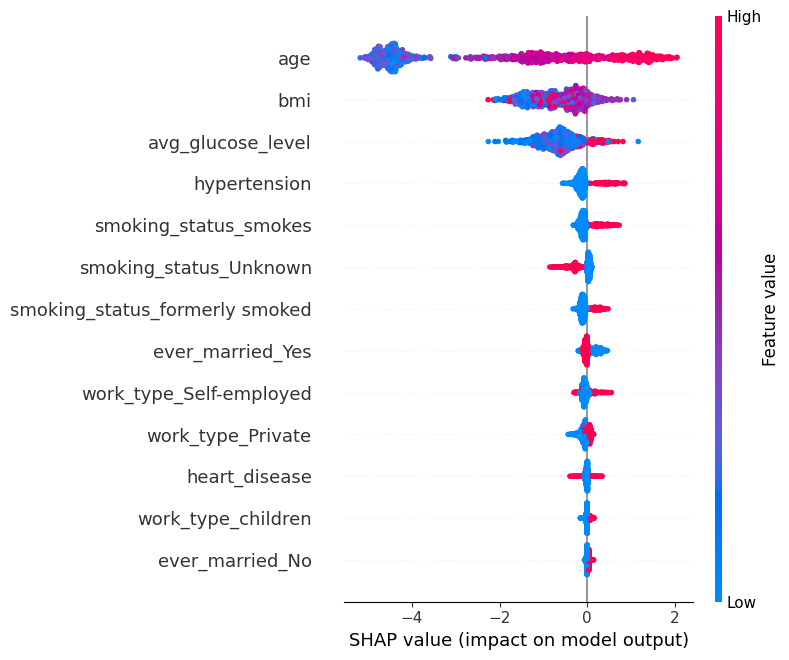

In [134]:

#model_name = [xgb]  # Use model objects, not strings
explainer = shap.TreeExplainer(xgb_after)
shap_values = explainer.shap_values(X_test_scaled_after)
shap.summary_plot(shap_values, X_test_scaled_after, feature_names=X_after.columns, show=False)
plt.savefig('SHAP_values_After.png')
plt.show()